PART 1 : DATA COLLECTION

This segment will go over the data collection process from the game World of Warcraft. For all intents and purposes you may skip this part if you're just here to learn python and data-analysis as that is the main focus of this project. This is more so for the people with a little extra time or curiousity to spare.

The World of Warcraft auction house works like you might expect - you put up listings for the items you own and people can either bid on them over a set amount of time or buy them outright at a price you set (often based on the current market value but undercutted slightly). Also to whom it may concern, I play World of Warcraft classic, which is basically a re-release of the game as it was back in the 2000's. There is the "retail" version of WoW which is what is kept up to date and given a new modern-looking expansion every few years but I just simply prefer to play the game as it was back in its glory years. The current version of the game has an official REST API / HTTP query system for querying data but that is not offered to world of warcraft "classic". Therefor I must do things manually from inside the game which is what lead to the long spiel below.

When I first set out to collect the auction house data my first thought was to scrape existing data from auction house addons that currently exist. Addons are third party programs that run in a contained environment within the game. They are written in lua and have highly restricted capabilities due to security measures put in place by the game developer. There already exists many auction house addons which essentially function by scanning the auction house for data (using the API made by the game developer), storing that data in memory, and then giving the player the price metrics they want whereever they might be needed. These addons are typically used to help streamline the auction house process in it's entirety - whether it be wanting to immediately know how much to undercut existing prices without having to search up each item then go back to the auctioning menu, automatically being told which items are being listed for less than usual and have a re-sell profit potential (often called auction sniping), or vice versa being told which items are being listed higher than usual based on past scan data suggesting that maybe you should wait until prices go back down. 

This is where I ran into my first issue. Often times these auction house addons aren't simple. They are made by recognized developers in the community that have been making and updating the addon from potentially even the release of the game in 2004. Therefor, these addons are huge and offer a lot of features which unfortunately didn't help my case when I was trying to navigate thousands of lines of code. Before this project I had never programmed in lua and trying to hunt down what I wanted in this goose chase was more than just time-consuming. Also the data structures in the save-data files were convoluted and tailored just to these addons. They all lacked the needed documentation for me to interpret what each random value meant in the unlabeled hundreds of thousands of rows inside the lua object snapshot where the data is saved.

So what did I decide to do? To make my own addon! This would give me the capability to format my own datastructure and really understand what's happening under the hood. I quickly realized some things. 0.) The API sucks and there's no official documentation just third party websites 1.) to efficiently scan the auction house you must make basically give the server a request to "scan all" which would display every item currently on the auction house on one page. You can only make this request every 15 to 20 minutes 2.) you must loop through every single item currently VIEWABLE on the auction house, as the "scan all" request doesn't actually return anything from the server but rather just sends a request to display auctions. 3.) There are many safety precautions, so in order to save your data you have to write down, in a descriptor file, specifically which variables the game will save off and then the game will take a snapshot of those variables when you logout and save them in a lua file. So with all that said, I begun my scans and on the server which I am currently playing, Maladath-US Alliance, 40,000 listings on average was what you might expect. After hours of head scratching and bug fixing I was finally able to get the game engine to save off my database for me to copy and plop into this project's files. Unforunately, the data files are just snapshots of lua variables (explaining the lua extension) so they will need to be converted if I want to use Pandas in python. Also, I changed up my data structure to something containing many more variables therefor friday's scan is a little lack luster. Also, due to human error I accidentally wrote over saturday's data file which is arguably the most important since prices go way up on the weekend which would've been cool to show.

There were plenty of bugs found along the way, like some listings lacking information when being scanned by my addon (including the name of all things). This is most likely due to a cache bug since I am trying to read out the auction house before each of the ~40000 listings are cached. After analyzing the code of existing auction house addons I notice that they have very sophisticated query systems to handle chunks of data at a time but unfortunately I do not have time to write a complete addon. All of the bugged listings still return their item ID which I could use to find the item data if I, for instance, made a table of every item in the game and it's information. Well, that's exactly what I did. However, nothing seems to be easy in this part of the project and as much as I wish things would "just work", it seems it's never that easy. So I begun the super fun adventure of scrounging the internet for a barely existent API for the original version of a game that came out 20 years ago to figure out how to basically download the games item data to a readable file. First, the code I wrote to query the game servers for every item in the game immediately crashed my game... over... and over... until I finally found the limit of how many items I could query from the server without absolutely obliterating my pc. So I basically just had to query the server in increments to get all the items. Another note is since the game doesn't save your variables as they update but rather takes a snapshot when you logout or reload your game, I'd crash on reload because it was just too much data for the game to push from memory to disk. After lot's of head scratching and bug fixing I finally had a database of every item in the game. 

With the scan data and the item data combined, we now had an awesome set of data to preform analysis on.

If you're interested, you may find my addon in the WoW_AddOn folder. LewAH (Lew Auction House) sure sounds like lua doesn't it ;)

*side note that if you do decide to use my addon know that it is absolutely not standalone and must be manually ran in a command prompt and its so finicky I wouldn't even recommend it without asking me*

An example scan output from LewAH may look like this:

In [145]:
#lewdb = {
#            ['scanDate'] = scan_date,           #date("%m/%d/%y %H:%M:%S")
#            [item_name1] = {
#                ['id'] = itemId, 
#                ['listings'] = {
#                    {texture, count, quality, canUse, level, levelColHeader, minBid, minIncrement, buyoutPrice, bidAmount, highBidder, bidderFullName, owner, ownerFullName, saleStatus},
#                    {texture, count, quality, canUse, level, levelColHeader, minBid, minIncrement, buyoutPrice, bidAmount, highBidder, bidderFullName, owner, ownerFullName, saleStatus},
#                    ...
#                }
#            },
#            [item_name2] = {
#                ['id'] = itemId, 
#                ['listings'] = {
#                    {texture, count, quality, canUse, level, levelColHeader, minBid, minIncrement, buyoutPrice, bidAmount, highBidder, bidderFullName, owner, ownerFullName, saleStatus},
#                    {texture, count, quality, canUse, level, levelColHeader, minBid, minIncrement, buyoutPrice, bidAmount, highBidder, bidderFullName, owner, ownerFullName, saleStatus},
#                    ...
#                }
#            },
#            ...
#        }
#}

The LewAH addon produces a nested lua table for each listed item and respective listing. As we need to import this data into pandas, I wrote a program called "csv_gen.lua" that takes a filename (produced from LewAH) and maps it to a .csv file. I use nested stateless iterators (ipairs) to index through each item and listing (as well as looking up itemids in the item-database table), recursively flattening the list of attributes so that it may be easily formatted and displayed as a .csv entry. The source code, shown below, can also be found in the scripts folder. 

```lua
-- change filename to scan data (ex. "Dec_12")
filename = "Dec_13"

listings = {"texture", "count", "quality", "canUse", "level",
 	"levelColHeader", "minBid", "minIncrement", "buyoutPrice",
  	"bidAmount", "highBidder", "bidderFullName", "owner",
   	"ownerFullName", "saleStatus", "itemName", "itemLink", "itemRarity", "itemLevel", "itemMinLevel", "itemType", "itemSubType", "itemStackCount", 
         "itemEquipLoc", "itemTexture", "itemSellPrice", "classID", "subclassID", "bindType", "expacID", "setID", "isCraftingReagent"}

current_dir=(io.popen"cd":read'*l'):sub(1, -8):gsub("\\", "/") .. "Data/"

file = io.open(current_dir .. filename .. ".csv", "a")
file:write("name,")
file:write("id,")

cats = ""
for _, category in ipairs(listings) do
	cats = cats .. category .. ","
end
cats = cats:sub(1,-2)
file:write(cats, "\n")


local f = assert(loadfile(current_dir .. filename .. ".lua"))
f()
local fd = assert(loadfile(current_dir .. "item-database" .. ".lua"))
fd()

function flattenRecursive(e, result)
    if type(e) == "table" then
        for k,v in pairs(e) do
            flattenRecursive(v, result)
        end
    else
        table.insert(result, e)
    end
end

function flatten (e)
    local result = {}
    flattenRecursive(e, result)
    return result
end

function isInteger(str)
	return not (str == "" or str:find("%D"))
end

scandate = ""

function csv_gen(tb)
	if type(tb) == 'table' then
		for k,v in pairs(tb) do
			id = -1
			if k == 'scanDate' then
				scandate = v
			else
				for k1,v1 in pairs(v) do
					if k1 == 'id' then
						id = v1
					end
					if type(v1) == 'table' then
						for k2,v2 in pairs(v1) do
							res = ""
							print(k, "listing #", k2, "----------")
							if isInteger(k) then
								res = res .. itemdb[k][1] .. ","
							else 
								res = res .. k .. ","
							end
							res = res .. id .. ","
							for k3,v3 in pairs(flatten(v2)) do
								res = res .. tostring(v3) .. ","
							end
							for k3,v3 in pairs(itemdb[tostring(id)]) do
								res = res .. tostring(v3) .. ","
							end
							res = res:sub(1,-2)
							file:write(res, "\n")
						end
					end
				end
			end
		end
	end
end

csv_gen(lewdb)

file:write(scandate, "\n")

io.close(file)
```

Part 2 : Data management/representation

So for this tutorial, you're first going to need to install python if you don't already have it, and get an envrionment up and running!

We will use a package called "pandas" in order to contain, and preform work on, the data.

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
dec11 = pd.read_csv("Data/Dec_11.csv", low_memory=False)
dec12 = pd.read_csv("Data/Dec_12.csv", low_memory=False)
dec13 = pd.read_csv("Data/Dec_13.csv", low_memory=False)
dec14 = pd.read_csv("Data/Dec_14.csv", low_memory=False)
dec15 = pd.read_csv("Data/Dec_15.csv", low_memory=False)
dec16 = pd.read_csv("Data/Dec_16.csv", low_memory=False)

# Last line of .csv is date - format it into datetime column ['scan_date']
def extract_date(df):
  df['scan_date'] = pd.to_datetime(df.iloc[-1][0]).day
  return df[:-1]

dec11 = extract_date(dec11)
dec12 = extract_date(dec12)
dec13 = extract_date(dec13)
dec14 = extract_date(dec14)
dec15 = extract_date(dec15)
dec16 = extract_date(dec16)

# Merge all CSVs into single pandas db
merged = pd.concat([dec11, dec12, dec13, dec14, dec15, dec16], ignore_index=True)

# convert every dtype manually later before it becomes an issue :(
merged["canUse"] = merged["canUse"].apply(lambda x: pd.to_numeric(x, errors = 'ignore'))
merged["highBidder"] = merged["highBidder"].apply(lambda x: pd.to_numeric(x, errors = 'ignore'))
merged["isCraftingReagent"] = merged["isCraftingReagent"].apply(lambda x: pd.to_numeric(x, errors = 'ignore'))

# Correct broken ['level'] entries with supplementary iteminfo data
for index, row in merged.iterrows():
  if row['level'] > 9000: #ITS OVER NINE THOUSAAAAAND
    merged.at[index, 'level'] = row['itemMinLevel']

#print(merged["canUse"].dtype)

merged

,name,id,texture,count,quality,canUse,level,levelColHeader,minBid,minIncrement,...,itemEquipLoc,itemTexture,itemSellPrice,classID,subclassID,bindType,expacID,setID,isCraftingReagent,scan_date
0,Aurora Pants,4044.0,134581.0,1.0,2.0,True,35.0,REQ_LEVEL_ABBR,40000.0,0.0,...,INVTYPE_LEGS,134581.0,4584.0,4.0,1.0,2.0,254.0,-777.0,False,11
1,Aurora Pants,4044.0,134581.0,1.0,2.0,True,35.0,REQ_LEVEL_ABBR,19000.0,0.0,...,INVTYPE_LEGS,134581.0,4584.0,4.0,1.0,2.0,254.0,-777.0,False,11
2,Severing Axe of the Bear,4562.0,135420.0,1.0,2.0,False,5.0,REQ_LEVEL_ABBR,2850.0,0.0,...,INVTYPE_2HWEAPON,135420.0,298.0,2.0,1.0,2.0,254.0,-777.0,False,11
3,Severing Axe of the Bear,4562.0,135420.0,1.0,2.0,False,5.0,REQ_LEVEL_ABBR,2850.0,0.0,...,INVTYPE_2HWEAPON,135420.0,298.0,2.0,1.0,2.0,254.0,-777.0,False,11
4,Portable Bronze Mortar,4403.0,134535.0,1.0,1.0,False,1.0,REQ_LEVEL_ABBR,90000.0,0.0,...,MISSING,134535.0,2000.0,7.0,3.0,0.0,254.0,-777.0,False,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201282,The Jade Eye,20959.0,133353.0,1.0,2.0,True,32.0,REQ_LEVEL_ABBR,44021.0,0.0,...,INVTYPE_FINGER,133353.0,1720.0,4.0,0.0,2.0,254.0,-777.0,False,16
201283,The Jade Eye,20959.0,133353.0,1.0,2.0,True,32.0,REQ_LEVEL_ABBR,44021.0,0.0,...,INVTYPE_FINGER,133353.0,1720.0,4.0,0.0,2.0,254.0,-777.0,False,16
201284,The Jade Eye,20959.0,133353.0,1.0,2.0,True,32.0,REQ_LEVEL_ABBR,44021.0,0.0,...,INVTYPE_FINGER,133353.0,1720.0,4.0,0.0,2.0,254.0,-777.0,False,16
201285,The Jade Eye,20959.0,133353.0,1.0,2.0,True,32.0,REQ_LEVEL_ABBR,44021.0,0.0,...,INVTYPE_FINGER,133353.0,1720.0,4.0,0.0,2.0,254.0,-777.0,False,16


In [147]:
# if there exists a buyout price then that is the price that we will use otherwise check to see what the highest bid value is

def getPrice(r):
    if(r['buyoutPrice'] == 0):
        if(r['bidAmount'] == 0):
            return int(r['minBid']/r['count']);
        else: 
            return int(r['bidAmount']/r['count']);
    else:
        return int(r['buyoutPrice']/r['count']);

#make a copy of the original data in case we want to reference the original.
df = merged.copy();
idf = open('Data/item-descriptor.json', 'r');
itemDescriptor = json.load(idf);


# For this part I made a JSON file based on the item key values I found in the api. I use 
# that file to change the classID, subclassID, and itemRarity to something that is readable

price = []
for i, r in df.iterrows():
    classID = itemDescriptor["classID"][int(r['classID'])]
    df.at[i, 'classID'] = classID['name']
    df.at[i, 'subclassID'] = classID["sub"][int(r['subclassID'])]
    df.at[i, 'itemRarity'] = itemDescriptor["itemQuality"][int(r['itemRarity'])]

# chop off annoying text prefixes
    if r['itemEquipLoc'] != "MISSING":
        df.at[i, 'itemEquipLoc'] = r['itemEquipLoc'][8:]

    price.append(getPrice(r));

df['price'] = price;
#dropping a whole bunch of columns that we wont be using in our analysis
df.drop(columns=['texture', 'quality', 'itemMinLevel', 'levelColHeader', 'canUse', 'itemTexture', 'expacID', \
    'highBidder', 'bidderFullName', 'owner', 'ownerFullName', 'saleStatus', 'itemLink', 'bindType', "itemStackCount", \
    'minBid', 'minIncrement', 'buyoutPrice', 'bidAmount', ], inplace=True);

#make columns easier to understand
df.rename(columns={"itemName": "itemIDName", "itemSellPrice": "vendorPrice", "count": "quantity"}, inplace=True);

df

,name,id,quantity,level,itemIDName,itemRarity,itemLevel,itemType,itemSubType,itemEquipLoc,vendorPrice,classID,subclassID,setID,isCraftingReagent,scan_date,price
0,Aurora Pants,4044.0,1.0,35.0,Aurora Pants,Uncommon,40.0,Armor,Cloth,LEGS,4584.0,Armor,Cloth,-777.0,False,11,50000
1,Aurora Pants,4044.0,1.0,35.0,Aurora Pants,Uncommon,40.0,Armor,Cloth,LEGS,4584.0,Armor,Cloth,-777.0,False,11,28750
2,Severing Axe of the Bear,4562.0,1.0,5.0,Severing Axe,Uncommon,10.0,Weapon,Two-Handed Axes,2HWEAPON,298.0,Weapon,Axe2H,-777.0,False,11,3000
3,Severing Axe of the Bear,4562.0,1.0,5.0,Severing Axe,Uncommon,10.0,Weapon,Two-Handed Axes,2HWEAPON,298.0,Weapon,Axe2H,-777.0,False,11,3000
4,Portable Bronze Mortar,4403.0,1.0,1.0,Portable Bronze Mortar,Common,33.0,Trade Goods,Devices,MISSING,2000.0,Tradegoods,Devices,-777.0,False,11,90000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201282,The Jade Eye,20959.0,1.0,32.0,The Jade Eye,Uncommon,37.0,Armor,Miscellaneous,FINGER,1720.0,Armor,Miscellaneous,-777.0,False,16,46337
201283,The Jade Eye,20959.0,1.0,32.0,The Jade Eye,Uncommon,37.0,Armor,Miscellaneous,FINGER,1720.0,Armor,Miscellaneous,-777.0,False,16,46337
201284,The Jade Eye,20959.0,1.0,32.0,The Jade Eye,Uncommon,37.0,Armor,Miscellaneous,FINGER,1720.0,Armor,Miscellaneous,-777.0,False,16,46337
201285,The Jade Eye,20959.0,1.0,32.0,The Jade Eye,Uncommon,37.0,Armor,Miscellaneous,FINGER,1720.0,Armor,Miscellaneous,-777.0,False,16,46337


PART 3: Exploratory data analysis

In [148]:
#returns an array of how much gold silver and copper an item price is.

def toGSC(money):
    m = str(int(money))
    gold = ('0' if m[:-4] == '' else m[:-4]);
    silver = ('0' if m[-4:-2] == '' else m[-4:-2]);
    copper = m[-2:];
#    print(gold+' gold')
#    print(silver+' silver')
#    print(copper+' copper')
    return [gold, silver, copper];

def toGSCString(money):
    m = str(int(money))
    gold = ('0' if m[:-4] == '' else m[:-4]);
    silver = ('0' if m[-4:-2] == '' else m[-4:-2]);
    copper = m[-2:];
#    print(gold+' gold')
#    print(silver+' silver')
#    print(copper+' copper')
    return gold+"G "+silver+"S "+copper+"C";

For this part we explored how 3 of the most common materials right now are traded across the days that we have been collecting data. Tragically we did not have as much data as we would've hoped to. The inital hypothesis was to look at how item prices change over time, specifically on the weekends where I for a fact know prices tend to increase. This project is more of a proof of concept that you could infact follow this guide and get real use out of it if assuming you just had more data.

Text(0.5, 1.0, 'Day vs price : Frost Lotus')

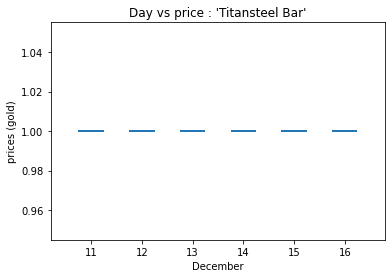

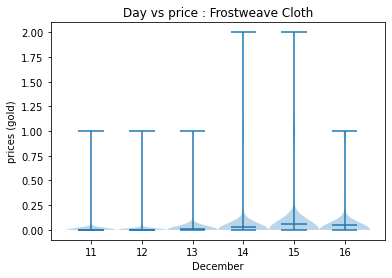

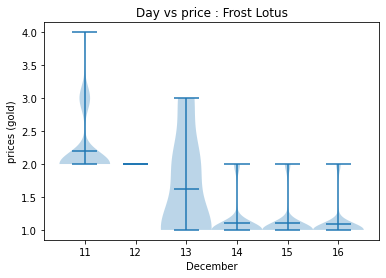

In [156]:


#create a sub table of titansteel bar listings
ore = df[df.name == 'Titansteel Bar'];

days = [];
prices = [];
#loop through all scans for titansteel bars and make a violin plot
for x in ore['scan_date'].unique():
    days.append(x);
    prices.append([int(toGSC(e)[0]) for e in ore[ore['scan_date'] == x]['price'].tolist()]);



fig, ax = plt.subplots()
ax.violinplot(prices,days,widths=1,showmeans=True)
ax.set_xlabel("December")
ax.set_ylabel("prices (gold)")
ax.set_title("Day vs price : 'Titansteel Bar'")

cloth = df[df.name == 'Frostweave Cloth'];

days = [];
prices = [];
for x in cloth['scan_date'].unique():
    days.append(x);
    prices.append([int(toGSC(e)[0]) for e in cloth[cloth['scan_date'] == x]['price'].tolist()]);



fig, ax = plt.subplots()
ax.violinplot(prices,days,widths=1,showmeans=True)
ax.set_xlabel("December")
ax.set_ylabel("prices (gold)")
ax.set_title("Day vs price : Frostweave Cloth")

herb = df[df.name == 'Frost Lotus'];

days = [];
prices = [];
for x in herb['scan_date'].unique():
    days.append(x);
    prices.append([int(toGSC(e)[0]) for e in herb[herb['scan_date'] == x]['price'].tolist()]);



fig, ax = plt.subplots()
ax.violinplot(prices,days,widths=1,showmeans=True)
ax.set_xlabel("December")
ax.set_ylabel("prices (gold)")
ax.set_title("Day vs price : Frost Lotus")

For this part we explored items that were listed on the auction house at lower prices than you can get by simply vendoring the item to an npc. If you were keeping this program up to date then you would be able to snipe these auctions. Unfortunately, as we can see that in our over 200,000 listings collected over the past week only the items printed below were mistakenly listed for lower than they should be and the profit margins. Gold is largest denomination of currency and most people have thousands so the profit here is menial. 

In [150]:
for i, r in df.iterrows():
    if(r['vendorPrice'] > r['price']):
        print(r['name'], 'profit: ', toGSC(r['vendorPrice']-r['price']));

Red Wolf Meat profit:  0G 0S 1C
Icy Orb of the Owl profit:  1G 77S 93C
Light Hide profit:  0G 0S 1C
Mystery Meat profit:  0G 0S 1C
Bleeding Eye of Frost Protection profit:  2G 26S 77C
Solstice Staff of the Whale profit:  0G 2S 86C
Grimscale Vambraces of Spell Power profit:  0G 5S 58C
Vindicator Shoulderpads of Stamina profit:  0G 87S 32C
Murphstar of Power profit:  0G 48S 91C
Headstriker Sword of the Boar profit:  1G 26S 84C
Design: Ruby Serpent profit:  0G 21S 00C
Recipe: Wildvine Potion profit:  0G 8S 00C
Pattern: Red Linen Robe profit:  0G 0S 2C
Oiled Blunderbuss profit:  0G 1S 73C
Silk Bandage profit:  0G 0S 10C
Iron Buckle profit:  0G 0S 10C
Iron Buckle profit:  0G 0S 10C
Iron Buckle profit:  0G 0S 10C
Reinforced Chain Bracers profit:  0G 1S 38C
Tough Cloak profit:  0G 1S 66C
Bronze Warhammer profit:  0G 0S 41C
Bronze Warhammer profit:  0G 0S 41C
Laughing Skull Bracelets profit:  0G 18S 28C
